In [1]:
import os
import subprocess
import xarray as xr
import numpy as np
import pandas as pd
import pyproj as proj
import netCDF4 as nc4
from datetime import datetime

In [157]:
f1 = "/media/arawlins/Backups/DataSources/geoserver_data/FuelModels/Dead_FM/VP3pm/VP3pm_20180131.grid.nc"
f2 = "/media/arawlins/Backups/DataSources/geoserver_data/FuelModels/Dead_FM/Tmx/Tmx_20180131.grid.nc"

In [158]:
ds = xr.open_mfdataset([f1,f2], concat_dim="obs")
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 691, longitude: 886, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
Data variables:
    VP3pm      (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
    Tmx        (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
Attributes:
    units:       Percent wet over dry by weight.
    time:units:  Days since 2018-01-31 00:00:00
    crs:         +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 
    created:     23-04-2018


In [159]:
t = ds["Tmx"].isel(time=0)
vp = ds["VP3pm"].isel(time=0)

In [160]:
t

<xarray.DataArray 'Tmx' (latitude: 691, longitude: 886)>
dask.array<shape=(691, 886), dtype=float32, chunksize=(691, 886)>
Coordinates:
    time       datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
Attributes:
    transform:   [ 1.11975e+02  5.00000e-02  0.00000e+00 -9.97500e+00  0.0000...
    res:         [0.05 0.05]
    is_tiled:    0
    nodatavals:  99999.8984375

In [161]:
vp

<xarray.DataArray 'VP3pm' (latitude: 691, longitude: 886)>
dask.array<shape=(691, 886), dtype=float32, chunksize=(691, 886)>
Coordinates:
    time       datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
Attributes:
    transform:   [ 1.11975e+02  5.00000e-02  0.00000e+00 -9.97500e+00  0.0000...
    res:         [0.05 0.05]
    is_tiled:    0
    nodatavals:  99999.8984375

In [162]:
ea = vp * 0.1
es = 0.6108 * np.exp(17.27 * t / (t + 237.3))
d = np.clip(ea - es, None, 0)
dfmc = 6.79 + (27.43 * np.exp(1.05 * d))

In [163]:
dfmc = dfmc.expand_dims('time')

In [164]:
dfmc.coords

Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...

In [165]:
dfmc.dims

('time', 'latitude', 'longitude')

In [177]:
ds2 = dfmc.to_dataset('DFMC')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  """Entry point for launching an IPython kernel.


In [167]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 691, longitude: 886, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
Data variables:
    VP3pm      (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
    Tmx        (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
Attributes:
    units:       Percent wet over dry by weight.
    time:units:  Days since 2018-01-31 00:00:00
    crs:         +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 
    created:     23-04-2018

In [169]:
ds.to_netcdf("ds1.nc", format="NETCDF4")
ds.close()

In [178]:
ds2

<xarray.Dataset>
Dimensions:    (latitude: 691, longitude: 886, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
Data variables:
    DFMC       (time, latitude, longitude) float32 34.22 34.22 34.22 34.22 ...

In [180]:
ds2.to_netcdf("ds-2.nc", format="NETCDF4")
ds2.close()

In [181]:
with xr.open_mfdataset(["ds1.nc", "ds-2.nc"]) as d:
    print(d)
    d.to_netcdf('combination.nc', format='NETCDF4')
    d.close()

<xarray.Dataset>
Dimensions:    (latitude: 691, longitude: 886, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
Data variables:
    VP3pm      (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
    Tmx        (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
    DFMC       (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
Attributes:
    units:       Percent wet over dry by weight.
    time:units:  Days since 2018-01-31 00:00:00
    crs:         +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 
    created:     23-04-2018


In [182]:
import glob


# ds = xr.open_mfdataset(glob.glob("/media/arawlins/Backups/DataSources/geoserver_data/FuelModels/Dead_FM/DFMC/*.nc"))
ds = xr.open_mfdataset("combination.nc")
# if "observations" in ds.dims:
#     DS = ds.squeeze("observations")
# else:
DS = ds

print(DS)


<xarray.Dataset>
Dimensions:    (latitude: 691, longitude: 886, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
Data variables:
    VP3pm      (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
    Tmx        (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
    DFMC       (time, latitude, longitude) float32 dask.array<shape=(1, 691, 886), chunksize=(1, 691, 886)>
Attributes:
    units:       Percent wet over dry by weight.
    time:units:  Days since 2018-01-31 00:00:00
    crs:         +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 
    created:     23-04-2018


In [183]:
sr = DS["DFMC"].sel(latitude=slice(-10, -15)).sel(longitude=slice(112,115))
print(sr)
ts = sr.loc[dict(time=slice('2018-01-31', '2018-01-31'))]

<xarray.DataArray 'DFMC' (time: 1, latitude: 100, longitude: 61)>
dask.array<shape=(1, 100, 61), dtype=float32, chunksize=(1, 100, 61)>
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.05 -10.1 -10.15 -10.2 -10.25 -10.3 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...


In [7]:
from matplotlib import pyplot as plt

In [125]:
ts

<xarray.DataArray 'DFMC' (time: 31, latitude: 100, longitude: 61)>
dask.array<shape=(31, 100, 61), dtype=float32, chunksize=(1, 100, 61)>
Coordinates:
  * latitude   (latitude) float64 -10.05 -10.1 -10.15 -10.2 -10.25 -10.3 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
  * time       (time) datetime64[ns] 2018-01-13 2018-01-14 2018-01-15 ...
Attributes:
    units:      Percentage wet over dry by weight.
    long_name:  Dead Fuel Moisture Content
    crs:        +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 

<xarray.DataArray 'DFMC' (latitude: 100, longitude: 61)>
dask.array<shape=(100, 61), dtype=float32, chunksize=(100, 61)>
Coordinates:
    time       datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.05 -10.1 -10.15 -10.2 -10.25 -10.3 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
26.188572
34.22
32.96747589111328
2.050560712814331
31/01/2018


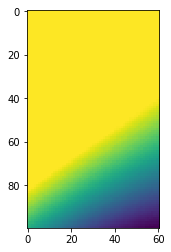

In [192]:
import datetime as dt

for t in range(0, len(sr["time"])):
    b=sr.isel(time=t)
    print(b)
    bin_ = b.to_dataframe()
    print(bin_["DFMC"].min())
    print(bin_["DFMC"].max())
    print(bin_["DFMC"].mean())
    print(bin_["DFMC"].std())
    
    print(bin_["time"].max().strftime("%d/%m/%Y"))
    
    plt.imshow(sr.isel(time=t))
    plt.show()

In [150]:
ds2["DFMC"].sel(latitude=slice(-10, -15)).sel(longitude=slice(112,115))

<xarray.DataArray 'DFMC' (time: 1, latitude: 100, longitude: 61)>
array([[[34.22    , 34.22    , ..., 34.22    , 34.22    ],
        [34.22    , 34.22    , ..., 34.22    , 34.22    ],
        ...,
        [31.40641 , 31.298946, ..., 26.327744, 26.311382],
        [31.256058, 31.149292, ..., 26.225372, 26.188572]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-31
  * latitude   (latitude) float64 -10.05 -10.1 -10.15 -10.2 -10.25 -10.3 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...

Spatially restricted dataset is:

<xarray.Dataset>
Dimensions:    (latitude: 691, longitude: 886, time: 365)
Coordinates:
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 -10.15 -10.2 -10.25 ...
  * longitude  (longitude) float64 112.0 112.0 112.1 112.1 112.2 112.2 112.3 ...
  * time       (time) datetime64[ns] 2017-09-18 2017-09-19 2017-09-20 ...
Data variables:
    VP3pm      (time, latitude, longitude) float32 dask.array<shape=(365, 691, 886), chunksize=(1, 691, 886)>
    Tmx        (time, latitude, longitude) float32 dask.array<shape=(365, 691, 886), chunksize=(1, 691, 886)>
    P          (time, latitude, longitude) float32 dask.array<shape=(365, 691, 886), chunksize=(1, 691, 886)>
    DFMC       (time, latitude, longitude) float32 dask.array<shape=(365, 691, 886), chunksize=(1, 691, 886)>
Attributes:
    time:units:        Days since 2017-09-18 00:00:00
    crs:               +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 
    created:           24-04-2018
    output_freque

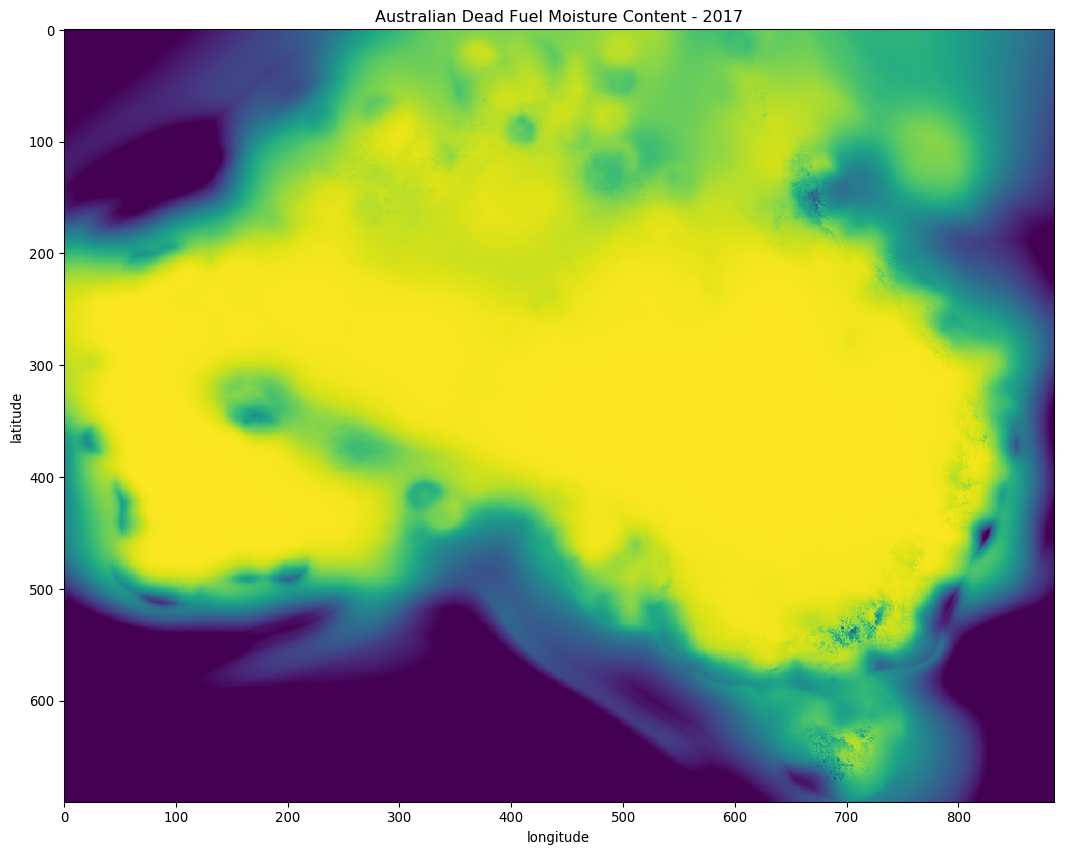

In [45]:
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(16, 9), dpi=96)
frames = []

plt.title('Australian Dead Fuel Moisture Content - 2017')
plt.ylabel('latitude')
plt.xlabel('longitude')
        
        
with xr.open_mfdataset(glob.glob("/media/arawlins/Backups/DataSources/geoserver_data/FuelModels/Dead_FM/DFMC/DFMC_2017*.nc")) as ds:
    sr = ds.squeeze('observations')
#     sr = DS.sel(latitude=slice(-12.1, -40), longitude=slice(115.0, 152.0))
    
    print("Spatially restricted dataset is:\n\n%s\n" % (sr))
    
    for t in range(0, len(sr["time"])):
        b = sr.isel(time=t)
        bin_ = b.to_dataframe()
        
        im = b["DFMC"]
        plt.tight_layout()
        frame = plt.imshow(im, animated=True, cmap=plt.cm.viridis_r)
        
#         print("{}, {}, {}, {}, {}\n".format( str(b["time"].values).replace('.000000000', '.000Z'),
#                                           bin_["DFMC"].mean(),
#                                           bin_["DFMC"].min(),
#                                           bin_["DFMC"].max(),
#                                           bin_["DFMC"].std()
#                                           ))
        frames.append([frame])
    vid = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
    
    vid.save('2017.mp4')
    plt.show()
